In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
from collections import Counter

from time import time

%matplotlib inline

import scipy.sparse

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('axes', labelsize='large') 

In [3]:
def id_counter(id_list):
    cnt = Counter()
    for el in id_list:
        cnt[el[u'element']] = el[u'count']
    return cnt

def_black_list = { 'unit', 'units', 'value', 'values', 'axis', 'axes', 'factor', 'factors', 'line', 'lines',
                 'point', 'points', 'number', 'numbers', 'variable', 'variables', 'respect', 'case', 'cases',
                 'vector', 'vectors', 'element', 'elements', 'example', 
                 'integer', 'integers', 'term', 'terms', 'parameter', 'parameters', 'coefficient', 'coefficients',
                 'formula', 'times', 'product', 'matrices', 'expression', 'complex', 'real', 'zeros', 'bits',
                 'sign',
                 'if and only if',
                 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 
                 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'}

def valid_def(definition):
    if len(definition) <= 3:
        return False

    return definition.lower() not in def_black_list

def rel_to_dict(rels):
    res = defaultdict(list)
    for r in rels:
        if not valid_def(r['definition']):
            continue
        res[r['identifier']].append((r['definition'], r['score']))
    return res

In [4]:
from collections import defaultdict

doc_categories = defaultdict(set)
category_docs = defaultdict(set)

for line in file('C:/tmp/mlp/category_info_refined.txt'):
    title, cat = line.strip().split('\t')
    title = title.decode('utf-8')
    cat = cat.decode('utf-8')

    # let's also remove all documents from "OTHER" category
    if cat == u'OTHER':
        continue

    doc_categories[title].add(cat) 
    category_docs[cat].add(title)

In [5]:
root = 'C:/tmp/mlp/mlp-output/'

docs = []
titles = []
ids = []
rels = []

empty = 0
small = 0
uncategorized = 0

for f in os.listdir(root): 
    for line in file(root + f):
        doc = json.loads(line)

        title = doc['title']        
        if title not in doc_categories:
            uncategorized = uncategorized + 1
            continue

        if '(disambiguation)' in title:
            continue

        id_bag = id_counter(doc['identifiers'])
        if len(id_bag) <= 1:
            if len(id_bag) == 0:
                empty = empty + 1
            else:
                small = small + 1
            continue

        docs.append(doc)
        titles.append(title)
        ids.append(id_bag)

        id_rels = rel_to_dict(doc['relations'])
        rels.append(id_rels)

print empty, small, uncategorized

N_doc = len(ids)
print N_doc

0 0 7501
22512


In [6]:
title_idx = {title: idx for (idx, title) in enumerate(titles)}

for doc, cats in doc_categories.items():
    if doc in title_idx:
        continue

    for cat in cats: 
        category_docs[cat].remove(doc)
    
    del doc_categories[doc]

print len(doc_categories)

22512


In [7]:
doc_categories_list = [doc_categories[doc] for doc in titles]

Let's remove definitions that occur just once - they are most likely noise

In [8]:
def_freq = Counter()

for def_dict in rels: 
    for id, def_list in def_dict.items():
        def_freq.update([d for d, s in def_list])

print def_freq.most_common(22)

[(u'time', 2464), (u'length', 1325), (u'distance', 1246), (u'matrix', 1230), (u'form', 1199), (u'radius', 1115), (u'mass', 1080), (u'angle', 1030), (u'order', 951), (u'sequence', 913), (u'degree', 904), (u'field', 880), (u'space', 879), (u'group', 786), (u'probability', 777), (u'temperature', 771), (u'velocity', 753), (u'constants', 735), (u'dimension', 714), (u'density', 700), (u'state', 661), (u'frequency', 640)]


In [9]:
low_freq_def = {id for id, cnt in def_freq.items() if cnt == 1}
print len(low_freq_def)

for def_dict in rels: 
    for id, def_list in def_dict.items():
        clean_def_list = []
        for definition, score in def_list:
            if definition not in low_freq_def:
                clean_def_list.append((definition, score))
        
        if not clean_def_list:
            del def_dict[id]
        else:
            def_dict[id] = clean_def_list

35144


Let's keep a copy of identifiers

In [10]:
ids = [id_counter(d['identifiers']) for d in docs]

In [11]:
import cluster_evaluation

In [12]:
reload(cluster_evaluation)
evaluate = cluster_evaluation.Evaluator(doc_titles=titles, doc_ids=ids, 
                                        doc_ids_definitions=rels, doc_categories=doc_categories_list)

In [13]:
all_ids = Counter()

for id_cnt in ids:
    all_ids.update(id_cnt)

infrequent = set()
min_count = 2

for (el, cnt) in all_ids.items():
    if cnt <= min_count:
        infrequent.add(el)

for id_cnt in ids:
    for id in (set(id_cnt) & infrequent):
        del id_cnt[id]

del all_ids
del infrequent

for def_dict in rels: 
    common = set(def_dict) & mc
    for id in common:
        del def_dict[id]

Now let's incorporate definitions into the vector space

In [14]:
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')

In [15]:
for idx in xrange(N_doc):
    vals = rels[idx].items()
    id_list = ids[idx]

    for id, definitions in vals:
        for definition, score in definitions:
            for unigram in definition.lower().split():
                stem = snowball_stemmer.stem(unigram)
                key = u'%s_%s' % (id, stem)
                id_list[key] = id_list[key] + 1

In [16]:
ids[201]

Counter({u'R_check': 2, u'R_digit': 2, u'N_4': 1, u'N_1': 1, u'N_2': 1, u'N_3': 1, u'R': 1, u'R_remaind': 1})

##  K-means

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, randomized_svd

In [18]:
def unwrap_counter(cnt):
    res = []
    for id, c in cnt.items():
        res.extend([id] * c)
    return res

vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=True, sublinear_tf=True, min_df=2)
X = vectorizer.fit_transform(ids)

In [19]:
X

<22512x37879 sparse matrix of type '<type 'numpy.float64'>'
	with 499070 stored elements in Compressed Sparse Row format>

In [20]:
499070.0 / (X.shape[0] * X.shape[1])

0.0005852600487697396

In [21]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(copy=False)

In [22]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [23]:
km_grid_hyperparam_res = {}
km_grid_hyperparam_lr = []

In [24]:
for n in [150, 250, 350, 500]:
    U, S, Vt = randomized_svd(X, n_components=n)
    V = Vt.T

    X_red_grid = X.dot(V)
    X_red_grid = normalizer.fit_transform(X_red_grid)

    ks = [k for k in xrange(500, 15001, 250)]
    
    for k in ks:
        km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km_grid.fit(X_red_grid)

        km_grid_hyperparam_res[(n, k)] = km_grid.labels_
        cluster_purity = evaluate.overall_purity(km_grid.labels_)
        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8, min_size=3))
        km_grid_hyperparam_lr.append((n, k, cluster_purity, no_pure_clusters))

        print 'purity for n=%d, k=%d is %0.4f, number of >0.8 clusters: %d' % (n, k, cluster_purity, no_pure_clusters)

purity for n=150, k=500 is 0.2231, number of >0.8 clusters: 20
purity for n=150, k=750 is 0.2302, number of >0.8 clusters: 24
purity for n=150, k=1000 is 0.2623, number of >0.8 clusters: 38
purity for n=150, k=1250 is 0.2633, number of >0.8 clusters: 42
purity for n=150, k=1500 is 0.2871, number of >0.8 clusters: 50
purity for n=150, k=1750 is 0.3091, number of >0.8 clusters: 74
purity for n=150, k=2000 is 0.3183, number of >0.8 clusters: 76
purity for n=150, k=2250 is 0.3290, number of >0.8 clusters: 68
purity for n=150, k=2500 is 0.3304, number of >0.8 clusters: 88
purity for n=150, k=2750 is 0.3381, number of >0.8 clusters: 80
purity for n=150, k=3000 is 0.3512, number of >0.8 clusters: 107
purity for n=150, k=3250 is 0.3750, number of >0.8 clusters: 119
purity for n=150, k=3500 is 0.3837, number of >0.8 clusters: 134
purity for n=150, k=3750 is 0.3941, number of >0.8 clusters: 128
purity for n=150, k=4000 is 0.4079, number of >0.8 clusters: 147
purity for n=150, k=4250 is 0.4136, n

In [25]:
import pickle

In [26]:
pickle.dump(km_grid_hyperparam_res, file('C:/tmp/mlp/namespaces/k-means-id-def-cleaned-07-25-svd.bin', 'w'))

In [27]:
df_nf = pd.DataFrame(km_grid_hyperparam_lr, columns=['n', 'k', 'purity', 'sizes'])
df_nf.head()

,n,k,purity,sizes
0,150,500,0.223081,20
1,150,750,0.230188,24
2,150,1000,0.262260,38
3,150,1250,0.263326,42
4,150,1500,0.287136,50


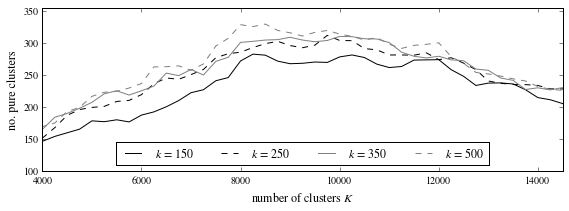

In [34]:
visual = {150: ('black', '-'), 250: ('black', '--'), 350: ('grey', '-'), 500: ('grey', '--')}

for n, g in df_nf.groupby('n'):
    color, line = visual[n]
    med = g.groupby('k').sizes.median()
    smoothed = pd.stats.moments.rolling_mean(med, window=3, center=True)
    smoothed.plot(figsize=(8, 3), label='$k$ = %d' % n, color=color, linestyle=line)


plt.grid(0)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')
plt.legend(loc='lower center', ncol=4)
plt.xlim(4000, 14500)
plt.ylim(100, 355)

plt.tight_layout()
plt.savefig('figures/k-vs-kmeans-len-svd-strong.pdf', format='pdf')
plt.show()

In [35]:
df_nf.ix[df_nf.sizes.argmax()]

n          500.000000
k         8250.000000
purity       0.568364
sizes      340.000000
Name: 208, dtype: float64

In [36]:
clustering = km_grid_hyperparam_res[(500, 8250)]
evaluate.report_overall(clustering, purity_threshold=0.8, min_size=3, sort_by='size')

overall purity 0.5684
number of high purity clusters of size at least 5 is 340

- Astronomical catalogues (id=509) size=53, purity=0.9811
- Set theory (id=1452) size=10, purity=0.9000
- Propositional calculus (id=6370) size=10, purity=0.8000
- Group theory (id=7478) size=10, purity=0.8000
- National Basketball Association seasons (id=482) size=9, purity=1.0000
- Electromagnetism (id=852) size=9, purity=0.8889
- Rotation (id=3355) size=9, purity=0.8889
- Numerical analysis (id=3480) size=9, purity=0.8889
- Algebraic geometry (id=7463) size=9, purity=0.8889
- Thermodynamics (id=220) size=8, purity=0.8750
- Coordinate systems (id=1151) size=8, purity=1.0000
- Numerical analysis (id=3390) size=8, purity=1.0000
- Quantum mechanics (id=4800) size=8, purity=0.8750
- Group theory (id=6385) size=8, purity=0.8750
- Fluid dynamics (id=81) size=7, purity=0.8571
- Financial economics (id=1829) size=7, purity=0.8571
- Rubber properties (id=2894) size=7, purity=1.0000
- Physical constants (id=4519) s

In [38]:
evaluate.print_cluster(clustering, 4606)

cluster 4606, size: 7
- Skew-symmetric matrix (categories: Linear algebra, Mathematical objects, Linear operators, Matrix theory, Matrices) Σ_a O_group Sym_n_space Γ Mat_n_space R_product x_implic Σ λ_1 θ λ_2 π B R_standard R_orthogon n_dimens Skew_n_space O R T b_sinθ O_orthogon s_sequenc R_matrix b m n R_inner p s O_lie w v y x Σ_form λ_r b_cosθ
- Diagonalizable matrix (categories: Linear algebra, Mathematical objects, Linear operators, Matrix theory, Matrices) P_invert b_eigenvalu P_vector Q_matrix λ_k_diagon u_eigenvalu v_1 M_eigenvector C_thumb λ_k_eigenvalu T_linear P_column T_map P_matrix λ_k_matrix Q_real λ_1 v_k λ_3 λ_2 C B D v_2 v_3 λ_j_root M Q P b T P_block M_power C_matrix λ_i λ_k λ_j λ_n λ_k_note λ_j_multipl k m n p B_matrix u v C_subset x
- Eigenvalues and eigenvectors (categories: Abstract algebra, Theoretical physics, Applied mathematics, Algebra, Linear algebra, ...) u_correspond k_matrix v_multipli ψ_E_oper Λ_matrix b_number R_0_averag v_n Q_squar t_G_person v_i v_j 

In [40]:
evaluate.find_identifier(clustering, purity_threshold=0.8, id=u'λ', min_size=3, collection_weighting=0)

overall purity 0.5684
number of high purity clusters of size at least 5 is 340

category "Fluid dynamics", cluster_id=81, size=7:
top categories: [(u'Fluid dynamics', 6), (u'Fluid mechanics', 6), (u'Dynamics', 6), (u'Waves', 4), (u'Physical oceanography', 4)]
     λ: (wavelength: 4.63), (specific volume conductivity*: 1.80), (mean depth*: 1.71), (medium: 0.91)
category "Lagrangian mechanics", cluster_id=115, size=4:
top categories: [(u'Lagrangian mechanics', 4), (u'Classical mechanics', 4), (u'Mechanics', 3), (u'Physics', 3), (u'Fields of mathematics', 2)]
     λ: (lagrange: 0.89), (multiplier: 0.83)
category "Applied and interdisciplinary physics", cluster_id=116, size=3:
top categories: [(u'Applied and interdisciplinary physics', 3), (u'Electromagnetic radiation', 2), (u'Fluid dynamics', 2), (u'Wave mechanics', 2), (u'Partial differential equations', 2)]
     λ: (wavelength: 3.57)
category "Probability theory", cluster_id=209, size=3:
top categories: [(u'Probability theory', 3), (u'L

## Using MSC and PACS

### MSC

Data taken from http://cran.r-project.org/web/classifications/MSC.html

In [41]:
tree = {}

top_parent = None
parent = None

for line in file('C:/tmp/mlp/msc.txt'):
    if line.startswith('#'):
        continue

    tabs = sum(1 for s in line[:8] if s == ' ') / 4
    code, name = line.strip().split(': ', 1)
    name = name.decode('utf-8')
    name = name.replace('$', '')
    
    if code.endswith('99'):
        # 'Miscellaneous topics' or 'None of the above, but in this section'
        continue
  
    if tabs == 0:
        top_parent = name
        tree[top_parent] = {}
    elif tabs == 1:
        parent = name
        tree[top_parent][parent] = []
    else:
        tree[top_parent][parent].append(name)

Let's remove categories without subcategories: they anyways are usually precedings or historical or monographs. "Aplications" subcategories don't seem to be very useful - remove as weel. Finally, let's remove some top categories like "general", "History" etc

In [42]:
del tree['General']
del tree['History and biography']
del tree['Mathematics education']

Some are physics specific that have many common words, so let's remove than and let PACS be used

In [43]:
del tree['Quantum theory']['Axiomatics, foundations, philosophy']
del tree['Quantum theory']['Applications to specific physical systems']
del tree['Quantum theory']['Groups and algebras in quantum theory']

In [44]:
del tree['Partial differential equations']['Equations of mathematical physics and other areas of application']
del tree['Statistics']['Sufficiency and information']
del tree['Functional analysis']['Other (nonclassical) types of functional analysis']
del tree['Functional analysis']['Miscellaneous applications of functional analysis']

In [45]:
for k_top, top in tree.items():
    for k_2, v in top.items():
        if not v:
            del top[k_2]
        elif k_2 == u'Applications':
            del top[k_2]
        elif 'proceedings' in k_2.lower() or 'conferences' in k_2.lower() or 'collections' in k_2.lower():
            del top[k_2]

### PACS

data taken from https://github.com/teefax/pacsparser

In [46]:
import re

In [47]:
tree_pacs = {}

top_top_parent = None
top_parent = None
parent = None

pacs_file = file('C:/tmp/mlp/pacs.txt')
# head = [next(pacs_file) for x in xrange(100)]

see_also_re = re.compile('\(see also.+?\)')
for_see_re = re.compile('\(for.+?see.+?\)')
tags_re = re.compile('<[^ ].*?>')

for line in pacs_file:
    if line.startswith('#'):
        continue
    if not line.strip():
        continue

    line = line.strip()
    code = line[0:8]
    if code.strip() == '... ...':
        continue

    if code == 'APPENDIX':
        break
        
    name = line[9:].decode('utf-8').replace('$', '')

    name = see_also_re.sub('', name)
    name = for_see_re.sub('', name)
    name = tags_re.sub('', name)

    codes = code.split('.')
    if len(codes) < 3:
        print code
    is_top_level =  False

    if codes[0].isdigit():
        top_code = int(codes[0])
        is_top_level = (top_code % 10 == 0) & (codes[1] == '00') & (codes[2] == '00')

    if is_top_level:
        top_top_parent = name
        tree_pacs[top_top_parent] = {}
    elif (codes[1] == '00') & (codes[2] == '00'):
        top_parent = name
        tree_pacs[top_top_parent][top_parent] = {}
    elif codes[2][0] in ['+', '-']:
        parent = name
        tree_pacs[top_top_parent][top_parent][parent] = []
    else: # tabs == 0
        tree_pacs[top_top_parent][top_parent][parent].append(name)

In [48]:
tree_pacs.keys()

[u'THE PHYSICS OF ELEMENTARY PARTICLES AND FIELDS ',
 u'NUCLEAR PHYSICS',
 u'CONDENSED MATTER: ELECTRONIC STRUCTURE, ELECTRICAL, MAGNETIC, AND OPTICAL PROPERTIES',
 u'CONDENSED MATTER: STRUCTURAL, MECHANICAL, AND THERMAL PROPERTIES',
 u'ATOMIC AND MOLECULAR PHYSICS',
 u'PHYSICS OF GASES, PLASMAS, AND ELECTRIC DISCHARGES',
 u'GEOPHYSICS, ASTRONOMY, AND ASTROPHYSICS ',
 u'ELECTROMAGNETISM, OPTICS, ACOUSTICS, HEAT TRANSFER, CLASSICAL MECHANICS, AND FLUID DYNAMICS',
 u'INTERDISCIPLINARY PHYSICS AND RELATED AREAS OF SCIENCE AND TECHNOLOGY',
 u'GENERAL']

Can remove the 'GENERAL' section since it should be covered by MCS or it's not interesing

In [49]:
del tree_pacs['GENERAL']

PACS categories seem to fine-grained - let's make it less fine-grained by folding low-level categories

In [50]:
pacs = {}
for k_0, cat_top in tree_pacs.items():
    for k_1, cat in cat_top.items():
        pacs[k_0 + ' ' + k_1] = cat

In [51]:
general_pacs = {}
for k_0, cat_top in tree_pacs.items():
    general_pacs[k_0] = {}

    for k_1, cat in cat_top.items():
        desc = []
        for k_2, low_cat in cat.items():
            desc.append(k_2)
            desc.extend(low_cat)
        
        general_pacs[k_0][k_1] = desc

### Wikipedia Categories

MSC's "Statistics" category doesn't seem to be good enough - statistical clusters gets mapped to anything else but stats. So let's create a stat category ourselves using wiki categories data 

In [52]:
wiki_tree = {}

In [53]:
narrower = defaultdict(set)
broader = defaultdict(set)

for line in file('C:/tmp/mlp/skos_math_broader.txt'):
    all_categories = line.decode('utf-8').strip().split('\t')
    
    child = all_categories[0]
    broader_list = all_categories[1:]

    for parent in broader_list:
        narrower[parent].add(child)
        broader[child].add(parent)

In [54]:
wiki_stat_category = set()

wiki_stat_category.update(narrower['Statistics'])

for cat in narrower['Statistics']:
    wiki_stat_category.update(narrower[cat])

wiki_tree['Statistics'] = {}
wiki_tree['Statistics']['Wiki statistics'] = wiki_stat_category

### ACM Classification Scheme

Can be downloaded from http://www.acm.org/about/class/class/2012 and has parsable skos format http://dl.acm.org/ft_gateway.cfm?id=2371137&ftid=1290922&dwn=1

In [55]:
import rdflib
from rdflib.namespace import SKOS

In [59]:
import logging
logging.getLogger('rdflib.term').setLevel(logging.ERROR)

In [60]:
g = rdflib.Graph()
g.load('C:/tmp/mlp/acm_skos_taxonomy.xml')

In [61]:
pref_len = len('file:///C://tmp/mlp/acm_skos_taxonomy.xml')

acm_titles = {}

for s, p, o in g.triples((None, SKOS.prefLabel, None)):
    if o.language != 'en':
        continue
    acm_titles[s[pref_len:]] = o.value

In [62]:
broader = defaultdict(set)
narrower = defaultdict(set)

for s, _, o in g.triples((None, SKOS.broader, None)):
    subj_title = acm_titles[s[pref_len:]]
    obj_title = acm_titles[o[pref_len:]]
    broader[subj_title].add(obj_title)
    narrower[obj_title].add(subj_title)

In [63]:
print ', '.join(narrower['Information systems'])
print ', '.join(broader['Data management systems'])

World Wide Web, Information storage systems, Data management systems, Information systems applications, Information retrieval
Information systems


In [64]:
top_level = ['Hardware', 'Computer systems organization', 'Networks', 'Software and its engineering',
             'Theory of computation', 'Information systems', 'Security and privacy', 'Human-centered computing',
             'Computing methodologies']

acm_tree = {}

def dfs(result, cat):
    result.append(cat)
    if cat in narrower:
        for n_cat in narrower[cat]:
            dfs(result, n_cat)
    return result

for most_top in top_level:
    acm_tree[most_top] = {}
    for cat in narrower[most_top]:
        acm_tree[most_top][cat] = dfs([], cat)

In [65]:
print ', '.join(acm_tree['Computing methodologies']['Machine learning'][:10])

Machine learning, Cross-validation, Learning settings, Online learning settings, Learning from demonstrations, Semi-supervised learning settings, Learning from implicit feedback, Batch learning, Learning from critiques, Active learning settings


## Category Index

Now we can build an index from these categories - and can find the most similar category fro each cluster

But first, let's merge MCS and PACS and other categories

In [66]:
all_cat_tree = defaultdict(dict)

for d in [tree, wiki_tree, general_pacs, acm_tree]:
    for k, dict_inner in d.items():
        all_cat_tree[k].update(dict_inner)

In [67]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')

In [68]:
all_categories = []
all_categories_idx = {}

english_sw = set(stopwords.words('english') + 
                 ['etc', 'given', 'method', 'methods', 'theory', 'problem', 'problems', 'model', 'models'] + 
                 ['section'] + ['must', 'also'])

cnt = 0

for k_top, top in all_cat_tree.items():
    for k_2, v in top.items():
        top = ' '.join([k_top] * 3)
        document = top + ' ' + k_2 + ' ' + ' '.join(v)
        tokens = word_tokenize(document)
        tokens = [t.lower() for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in english_sw]
        # tokens = [snowball_stemmer.stem(t) for t in tokens]
        all_categories.append(tokens)
        all_categories_idx[cnt] = (k_top, k_2)
        cnt = cnt + 1

In [69]:
def dedup(lst):
    seen = set()
    result = []
    for el in lst:
        if el in seen:
            continue
        result.append(el)
        seen.add(el)
    return result

In [70]:
df = Counter()
for cat in all_categories:
    df.update(set(cat))

print df.most_common(20)

[(u'general', 160), (u'systems', 146), (u'analysis', 107), (u'functions', 96), (u'properties', 93), (u'spaces', 93), (u'structure', 87), (u'algebraic', 85), (u'equations', 85), (u'topics', 83), (u'applications', 81), (u'structures', 75), (u'including', 74), (u'differential', 71), (u'related', 69), (u'algebras', 68), (u'groups', 68), (u'special', 66), (u'generalizations', 64), (u'linear', 63)]


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity(lst): return lst
category_vectorizer = TfidfVectorizer(analyzer=identity).fit(all_categories)

In [72]:
cat_index = category_vectorizer.transform(all_categories)
cat_index

<534x5347 sparse matrix of type '<type 'numpy.float64'>'
	with 19847 stored elements in Compressed Sparse Row format>

### Indexing Clusters

Now let's apply the same transformation to clusters

In [73]:
cluster_assignment = clustering

In [75]:
descriptions = evaluate.high_purity_clusters(cluster_assignment, threshold=0.8, all_categories=1, min_size=3)
desc_ids = [d['cluster'] for d in descriptions]
len(desc_ids)

340

In [76]:
def counter_to_string(cnt, repeat=1):
    if repeat:
        return ' '.join([(word + ' ') * cnt for word, cnt in cl_cats.items()])
    else:
        return ' '.join(cnt.keys())

In [77]:
def all_definitions(clustering, cluster_index):
    indices, = np.where(clustering == cluster_index)
    
    all_defs = []
    for idx in indices: 
        idx = int(idx)
        for lst in rels[idx].values():
            for d, _ in lst:
                all_defs.extend(d.split())
    return all_defs

In [78]:
clusters_representation = []

for cl_id in desc_ids:
    cl_titles, cl_cats = evaluate.cluster_details(cluster_assignment, cl_id)
    #defs = all_definitions(clustering, cl_id)
    document = ' '.join(cl_titles) + ' ' + counter_to_string(cl_cats) #+ ' '.join(defs)
    tokens = word_tokenize(document)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in english_sw]
    # tokens = [snowball_stemmer.stem(t) for t in tokens]
    clusters_representation.append(tokens)

In [79]:
clus_index = category_vectorizer.transform(clusters_representation)
clus_index

<340x5347 sparse matrix of type '<type 'numpy.float64'>'
	with 8188 stored elements in Compressed Sparse Row format>

In [80]:
clus_cat_sim = (clus_index * cat_index.T).toarray()
best_similarity = clus_cat_sim.max(axis=1)
clus_cat_assignment = clus_cat_sim.argmax(axis=1)
clus_cat_assignment

array([ 54, 401, 275, 418, 107,  82,  52,   8, 423, 385, 202, 172,  82,
       402, 301, 278, 348,  25,  68, 397, 433, 443,  65, 443, 420, 345,
        52,  82,  84,  68, 453, 368, 371, 385,  82, 484, 441, 194, 331,
       197, 342, 113, 383, 378, 433, 401, 422, 107,  70,  68, 348, 250,
       430, 305, 197, 331, 418, 443, 267, 308, 420, 476, 442,  72, 433,
       381,  85,  40,  74, 373, 402, 275, 202,  15, 420, 174,  26, 514,
        74, 383,  65, 246, 325, 456, 385, 194, 197, 344, 401,  64,  15,
       305, 275, 330,  65, 275, 265, 109, 368, 505, 380, 401, 375, 202,
        66, 527, 442,   2, 150,  73, 443, 174,  15, 104, 456, 531, 325,
       410, 407, 401, 420, 202,  84,  68, 386, 433, 476,   5, 479,  82,
       202, 512, 402,  64, 402,  51, 373,  73,  81, 483, 224, 401, 169,
        68, 371,  26,  74, 325, 479, 426, 196, 346, 490, 485, 528, 348,
       275,  26,   1, 443, 176, 312,  15, 114,  64, 411, 363,   1,  65,
       423,  19, 368, 345,  15, 322, 348, 527, 286, 446, 407, 20

In [87]:
clus_id = 10
evaluate.print_cluster(cluster_assignment, desc_ids[clus_id])

cluster 222, size: 3
- History of Maxwell's equations (categories: Physics, Theoretical physics, Dynamical systems, Differential equations, Mathematical physics, ...) ρ H_context σ E D H J E_charg c J_tot μ_0 ε_0 ϕ t v ε μ
- Eddy current (categories: Dynamical systems, Electromagnetism, Electrodynamics, Waste treatment technology, Biodegradable waste management, ...) d_thick E_electr ρ_resist δ_penetr δ_depth f_frequenc H_definit H_current J_current J_electr P_power M_magnet μ_0_permeabl B_faraday E_current μ_0 ρ_wire J_field μ_0_materi ρ_thin μ δ ρ π σ B E D μ_0_vacuum H J M B_law P J_ohm σ_electr P_follow E_field d J_densiti f E_densiti k σ_conduct δ_equat H_magnet H_densiti P_equat μ_permeabl D_densiti t J_law μ_magnet δ_follow H_field μ_0_definit
- A Dynamical Theory of the Electromagnetic Field (categories: Physics, Electromagnetism, Force, Special relativity, Academic journal articles, ...) ρ_charg D_forc V D_lorentz f_forc D_displac ϕ_electr J_current D_law D_ampèr ρ_densiti V_v

In [88]:
best_similarity[clus_id]

0.2809262204616656

In [89]:
print ', '.join(dedup(clusters_representation[clus_id]))

history, maxwell, equations, eddy, current, dynamical, electromagnetic, field, james, clerk, academic, journal, articles, wikipedia, categories, named, scottish, people, scientists, multivariable, calculus, special, relativity, physics, literature, partial, differential, electromagnetism, papers, waste, treatment, technology, force, systems, electrodynamics, concepts, mathematical, theoretical, biodegradable, management, mechanical, biological


In [90]:
idx = clus_cat_assignment[clus_id]
print all_categories_idx[idx]
print ', '.join(dedup(all_categories[idx]))

(u'Partial differential equations', u'Close-to-elliptic equations')
partial, differential, equations, hypoelliptic, subelliptic


Let's build a hierarchy:

In [91]:
namespaces = defaultdict(list)

for idx in range(len(desc_ids)):
    cat_id = clus_cat_assignment[idx]
    desc = descriptions[idx]

    score = best_similarity[idx]
    common_keywords = set(clusters_representation[idx]) & set(all_categories[cat_id])

    parent_cat, namespace_cat = all_categories_idx[cat_id]
    if score <= 0.2 or len(common_keywords) == 1:
        parent_cat = 'OTHER'

    namespaces[parent_cat].append((namespace_cat, score, desc, common_keywords))

namespaces = sorted(namespaces.items())

In [92]:
class Namespace():

    _parent = None
    _name = None
    _identifiers = None
    _children = None
    _relations = None
    _wiki_cats = None

    _cluster_id = None

    def __init__(self, name, parent=None):
        self._name = name
        self._children = []

        if parent:
            self._parent = parent
            self._parent._children.append(self)

    def set_wiki_categories(self, wiki_cats):
        self._wiki_cats = wiki_cats
        
    def most_common_wiki_cat(self):
        if self._wiki_cats:
            return self._wiki_cats.most_common(1)[0]
        else:
            return None

    def set_relations(self, relations):
        self._relations = relations

    def set_additional_info(self, cluster_id, purity, matching_score, matching_terms):
        self._cluster_id = cluster_id
        self._purity = purity
        self._matching_score = matching_score
        self._matching_terms = matching_terms

    def print_ns(self, indend=0, print_rels=0):
        indend_str = ' ' * (4 * indend)
        print indend_str, 'Category: %s' % self._name
        if self._wiki_cats:
            print indend_str, '          wiki categories:', 
            print ', '.join('%s (%d)' % (cat, cnt) for cat, cnt in self._wiki_cats.most_common(3))
        if self._cluster_id:
            print indend_str, '          cluster_id: %d (matching score: %0.2f, purity: %0.2f)' % \
                                    (self._cluster_id, self._matching_score, self._purity)
            print indend_str, '          common:', ' '.join(self._matching_terms)

        if print_rels and self._relations:
            for id, def_list in self._relations:
                print indend_str, '-',
                print evaluate._string_def_list(id, def_list) 
        
        print 
        for child in self._children:
            child.print_ns(indend+1, print_rels=print_rels)
            print
    
    def __repr__(self):
        return self._name

In [93]:
ROOT = Namespace('ROOT')

for parent_cat, groups in namespaces:
    parent_namespace = Namespace(parent_cat, ROOT)

    for cat, score, desc, common in groups:
        ns = Namespace(cat, parent_namespace)
        ns.set_wiki_categories(desc['all_categories'])

        wiki_category = ns.most_common_wiki_cat()
        cluster_id = desc['cluster']
        ns.set_additional_info(cluster_id, desc['purity'], score, common)

        all_def = evaluate.find_all_def(cluster_assignment, cluster_id) 
        all_items = sorted(all_def.items())
        ns.set_relations(all_items)

In [95]:
ROOT.print_ns(print_rels=0)

 Category: ROOT

     Category: ATOMIC AND MOLECULAR PHYSICS

         Category: Atomic properties and interactions with photons 
                   wiki categories: Physical constants (6), Atomic physics (5), Constants (5)
                   cluster_id: 4519 (matching score: 0.23, purity: 0.86)
                   common: rydberg electron optical atomic molecular physics


         Category: Atomic properties and interactions with photons 
                   wiki categories: Quantum mechanics (4), Atomic, molecular, and optical physics (3), Atomic physics (2)
                   cluster_id: 6857 (matching score: 0.28, purity: 1.00)
                   common: optical molecular physics atomic



     Category: Algebraic geometry

         Category: Affine geometry
                   wiki categories: Affine geometry (3), Fields of mathematics (2), Geometry (2)
                   cluster_id: 249 (matching score: 0.49, purity: 1.00)
                   common: geometry affine


         Categ

### Now let's merge them and push up common identifiers

In [313]:
top = ROOT._children[1]
print top
print 
ns1 = top._children[1]
ns1.print_ns(print_rels=1)
ns2 = algem._children[2]
ns2.print_ns(print_rels=1)

Algebraic geometry

 Category: Computational aspects in algebraic geometry
           wiki categories: Algebraic varieties (3), Geometry of divisors (2), Algebraic geometry (2)
           cluster_id: 675 (matching score: 0.65, purity: 1.00)
           common: geometry algebraic varieties
 - C: (open subset: 0.91), (meromorphic functions: 0.88), (surface: 0.86)
 - D: (divisor*: 5.51), (cartier: 2.69), (line bundle*: 1.76), (hypersurface: 0.95), (symbol deg: 0.87), (fano: 0.86)
 - H: (class: 0.89)
 - K: (canonical divisor: 0.92), (states: 0.91)
 - L: (holomorphic line bundle*: 1.68), (sections: 0.93), (equivalent way: 0.86), (special case: 0.82)
 - M: (presheaf: 0.92), (open subset u: 0.86)
 - M_X: (sheaf*: 2.78)
 - O: (structural sheaf: 0.96), (characteristic: 0.83)
 - O_X: (total quotient ring*: 1.79)
 - U_i: (sets: 0.99), (open cover: 0.83), (rational functions: 0.83), (collection: 0.83)
 - X: (riemann surface*: 1.91), (projective variety*: 1.74), (ample line bundle: 0.95), (topology:

In [1043]:
reload(cluster_evaluation)
evaluate = cluster_evaluation.Evaluator(doc_titles=titles, doc_ids=ids, 
                                        doc_ids_definitions=rels, doc_categories=doc_categories_list)

## DB-SCAN

## Score normalization

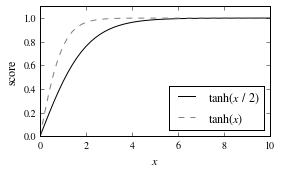

In [22]:
plt.figure(figsize=(4, 2.5))

x = np.linspace(0, 10, num=51)
plt.plot(x, np.tanh(x / 2), color='black', label='tanh($x\,/\,2$)')
plt.plot(x, np.tanh(x), '--', color='grey', label='tanh($x$)')

plt.ylim(0, 1.1)
plt.legend(loc='lower right')

plt.xlabel('$x$')
plt.ylabel('score')
plt.tight_layout()
plt.savefig('figures/tanh.pdf', format='pdf')
plt.show()

In [11]:
np.tanh(np.array([0, 0.5, 0.8, 0.9, 2, 3]))

array([ 0.        ,  0.46211716,  0.66403677,  0.71629787,  0.96402758,
        0.99505475])

In [12]:
np.tanh(np.array([0, 0.5, 0.8, 0.9, 2, 3]) / 2)

array([ 0.        ,  0.24491866,  0.37994896,  0.42189901,  0.76159416,
        0.90514825])

In [21]:
scores = np.array([1.90, 0.89, 0.99, 4.75, 0.99, 2.75, 0.95, 0.89, 0.89, 0.96, 2.86, 0.93,  ]) 
np.tanh(scores / 2).round(2)

array([ 0.74,  0.42,  0.46,  0.98,  0.46,  0.88,  0.44,  0.42,  0.42,
        0.45,  0.89,  0.43])